In [1]:
import sys
sys.path.append("..")  # Adds /lab3-1/ to sys.path for ridge_utils

import gensim
import os
import pickle 
import numpy as np
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from preprocessing import downsample_word_vectors, make_delayed

# Set up path
data_path = "/ocean/projects/mth240012p/shared/data"
raw_text_path = os.path.join(data_path, "raw_text.pkl")

# ----- Data split -----

# Load raw text
with open(raw_text_path, "rb") as f:
    raw_text = pickle.load(f)

# Train/test split
story_names = list(raw_text.keys())
train_stories, test_stories = train_test_split(story_names, test_size=0.2, random_state=42)



In [2]:
# ----- 1. Generate GloVe embeddings -----

# Load pre-trained GloVe (glove-wiki-gigaword-300, 300D)
glove_model = api.load("glove-wiki-gigaword-300")

# Convert for all stories
word_vectors = {}  # dictionary: story -> (T, 300)
for story in story_names:
    words = raw_text[story].data
    vectors = []
    for word in words:
        if word in glove_model:
            vectors.append(glove_model[word])
        else:
            vectors.append(np.zeros(300))  # Zero vector for out-of-vocabulary words
    word_vectors[story] = np.vstack(vectors)
    print(f"{story}: GloVe shape = {word_vectors[story].shape}")  # Expected shape: (T, 300)



sweetaspie: GloVe shape = (697, 300)
thatthingonmyarm: GloVe shape = (2073, 300)
tildeath: GloVe shape = (2297, 300)
indianapolis: GloVe shape = (1554, 300)
lawsthatchokecreativity: GloVe shape = (2084, 300)
golfclubbing: GloVe shape = (1211, 300)
jugglingandjesus: GloVe shape = (887, 300)
shoppinginchina: GloVe shape = (1731, 300)
cocoonoflove: GloVe shape = (1984, 300)
hangtime: GloVe shape = (1927, 300)
beneaththemushroomcloud: GloVe shape = (1916, 300)
dialogue4: GloVe shape = (1692, 300)
thepostmanalwayscalls: GloVe shape = (2220, 300)
stumblinginthedark: GloVe shape = (2681, 300)
kiksuya: GloVe shape = (1699, 300)
haveyoumethimyet: GloVe shape = (2985, 300)
theinterview: GloVe shape = (1079, 300)
againstthewind: GloVe shape = (838, 300)
tetris: GloVe shape = (1350, 300)
canplanetearthfeedtenbillionpeoplepart2: GloVe shape = (2532, 300)
alternateithicatom: GloVe shape = (2174, 300)
goldiethegoldfish: GloVe shape = (1680, 300)
seedpotatoesofleningrad: GloVe shape = (1376, 300)
onap

In [3]:
# ----- 2. Downsample and trim -----

wordseqs = raw_text
stories = train_stories + test_stories

def align_embeddings_with_fmri(stories, word_vectors, wordseqs, subject_path):
    """
    Aligns GloVe embeddings with FMRI recordings.
    Returns trimmed X and Y matched by timepoints.
    """
    # Downsample the embeddings
    downsampled = downsample_word_vectors(stories, word_vectors, wordseqs)

    # Trim the first 5 and last 10 seconds
    X_trimmed = {}
    Y_trimmed = {}

    for story in stories:
        bold_path = os.path.join(subject_path, f"{story}.npy")
        try:
            Y = np.load(bold_path)
            X = downsampled[story]

            # Explicitly trim first 5 and last 10 seconds
            # X = X[5:-10, :]  # Assumes 1 row = 1 second
            # Y = Y[5:-10, :]  # Trim Y to match

            # Match shortest timepoints across both (in case of mismatch)
            min_len = min(X.shape[0], Y.shape[0])

            X_trimmed[story] = X[:min_len, :]
            Y_trimmed[story] = Y[:min_len, :]

            print(f"{story}: aligned length = {min_len}")
        except FileNotFoundError:
            print(f"FMRI file for '{story}' not found, skipping.")
        except Exception as e:
            print(f"Error with {story}: {e}")
    
    return X_trimmed, Y_trimmed

subject_path = os.path.join(data_path, "subject2")
stories = train_stories + test_stories

X_trimmed, Y_trimmed = align_embeddings_with_fmri(stories, word_vectors, raw_text, subject_path)



theadvancedbeginner: aligned length = 318
superheroesjustforeachother: aligned length = 325
seedpotatoesofleningrad: aligned length = 281
mayorofthefreaks: aligned length = 475
adollshouse: aligned length = 241
cautioneating: aligned length = 279
haveyoumethimyet: aligned length = 496
ifthishaircouldtalk: aligned length = 249
myfathershands: aligned length = 170
thecurse: aligned length = 407
hangtime: aligned length = 324
breakingupintheageofgoogle: aligned length = 521
theclosetthatateeverything: aligned length = 314
leavingbaghdad: aligned length = 327
FMRI file for 'myfirstdaywiththeyankees' not found, skipping.
itsabox: aligned length = 355
golfclubbing: aligned length = 201
odetostepfather: aligned length = 404
gpsformylostidentity: aligned length = 326
exorcism: aligned length = 467
waitingtogo: aligned length = 349
theinterview: aligned length = 221
FMRI file for 'dialogue6' not found, skipping.
forgettingfear: aligned length = 237
FMRI file for 'dialogue5' not found, skipping.

In [4]:
# ----- 3. Create lagged versions of the features -----

# Apply make_delayed to all stories in X_trimmed
X_glove_lagged = {}

for story in X_trimmed:
    try:
        X_glove_lagged[story] = make_delayed(X_trimmed[story], delays=[1, 2, 3, 4])
        print(f"{story}: lagged shape = {X_glove_lagged[story].shape}")
    except Exception as e:
        print(f"Error for {story}: {e}")  # Expected shape: (T, 1200)

theadvancedbeginner: lagged shape = (318, 1200)
superheroesjustforeachother: lagged shape = (325, 1200)
seedpotatoesofleningrad: lagged shape = (281, 1200)
mayorofthefreaks: lagged shape = (475, 1200)
adollshouse: lagged shape = (241, 1200)
cautioneating: lagged shape = (279, 1200)
haveyoumethimyet: lagged shape = (496, 1200)
ifthishaircouldtalk: lagged shape = (249, 1200)
myfathershands: lagged shape = (170, 1200)
thecurse: lagged shape = (407, 1200)
hangtime: lagged shape = (324, 1200)
breakingupintheageofgoogle: lagged shape = (521, 1200)
theclosetthatateeverything: lagged shape = (314, 1200)
leavingbaghdad: lagged shape = (327, 1200)
itsabox: lagged shape = (355, 1200)
golfclubbing: lagged shape = (201, 1200)
odetostepfather: lagged shape = (404, 1200)
gpsformylostidentity: lagged shape = (326, 1200)
exorcism: lagged shape = (467, 1200)
waitingtogo: lagged shape = (349, 1200)
theinterview: lagged shape = (221, 1200)
forgettingfear: lagged shape = (237, 1200)
shoppinginchina: lagged

In [5]:
# ----- 4. Check -----
# Check if all train and test stories are in both X_glove_lagged and Y_trimmed
missing_train_glove = [story for story in train_stories if story not in X_glove_lagged]
missing_train_trimmed = [story for story in train_stories if story not in Y_trimmed]
missing_test_glove = [story for story in test_stories if story not in X_glove_lagged]
missing_test_trimmed = [story for story in test_stories if story not in Y_trimmed]

print(f"Missing in X_glove_lagged (train): {missing_train_glove}")
print(f"Missing in Y_trimmed (train): {missing_train_trimmed}")
print(f"Missing in X_glove_lagged (test): {missing_test_glove}")
print(f"Missing in Y_trimmed (test): {missing_test_trimmed}")

Missing in X_glove_lagged (train): ['myfirstdaywiththeyankees', 'dialogue6', 'dialogue5', 'dialogue3', 'dialogue2']
Missing in Y_trimmed (train): ['myfirstdaywiththeyankees', 'dialogue6', 'dialogue5', 'dialogue3', 'dialogue2']
Missing in X_glove_lagged (test): ['dialogue1', 'dialogue4', 'onlyonewaytofindout']
Missing in Y_trimmed (test): ['dialogue1', 'dialogue4', 'onlyonewaytofindout']


# Part 2 Modeling

In [12]:
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import pickle
import os

# Function to compute the correlation coefficient (CC) for each voxel
def compute_cc(y_true, y_pred):
    # Ensure we iterate only over the valid range of voxel indices
    num_voxels = min(y_true.shape[1], y_pred.shape[1])  # Take the minimum of both shapes to avoid out-of-bounds
    cc_vals = []

    # Loop over each voxel and compute the Pearson correlation
    for v in range(num_voxels):  # For each voxel
        cc, _ = pearsonr(y_true[:, v], y_pred[:, v])  # Compute correlation coefficient for voxel v
        cc_vals.append(cc)

    return np.array(cc_vals)

# ----- Stack training data -----
X_train = []
Y_train = []

# Load and stack data for training
for story in train_stories:
    if story in X_glove_lagged and story in Y_trimmed:
        X_train.append(X_glove_lagged[story])
        Y_train.append(Y_trimmed[story])

X_train = np.vstack(X_train)
Y_train = np.vstack(Y_train)

print(f"Before NaN removal: X_train {X_train.shape}, Y_train {Y_train.shape}")

# ----- Remove NaNs from Y_train -----
# Create mask for rows with no NaN values in Y
mask = ~np.isnan(Y_train).any(axis=1)

# Apply the mask to both X and Y
X_train_clean = X_train[mask]
Y_train_clean = Y_train[mask]

print(f"After NaN removal: X_train {X_train_clean.shape}, Y_train {Y_train_clean.shape}")

# ----- Compute the correlation coefficient (CC) on cleaned training data -----
ccs = compute_cc(Y_train_clean, X_train_clean)

# Print the Mean, Median, Top 1%, and Top 5% CC for the cleaned training data
print(f"Mean CC after NaN removal: {np.mean(ccs):.4f}")
print(f"Median CC after NaN removal: {np.median(ccs):.4f}")
print(f"Top 1% CC after NaN removal: {np.percentile(ccs, 99):.4f}")
print(f"Top 5% CC after NaN removal: {np.percentile(ccs, 95):.4f}")

# ----- Cross-validation to select the best alpha for Ridge Regression -----
def cross_validate_ridge(X, Y, alphas):
    """
    Cross-validates the Ridge regression model for different alphas and returns the best alpha.
    :param X: Feature matrix
    :param Y: FMRI response matrix
    :param alphas: List of alphas to try
    :return: Best alpha selected by cross-validation, and the corresponding CC results
    """
    best_alpha = None 
    best_cc = -np.inf
    cc_results = {}

    # For each alpha, perform cross-validation
    for alpha in tqdm(alphas, desc="Cross-Validation alphas", unit='alpha'):
        model = Ridge(alpha=alpha)
        # Calculate cross-validation CC scores for this alpha
        cv_scores = cross_val_score(model, X, Y, cv=5, scoring='neg_mean_squared_error')
        mean_cc = np.mean(cv_scores)  # Mean CC across the folds

        cc_results[alpha] = mean_cc

        # Select the best alpha based on the highest CC
        if mean_cc > best_cc:
            best_cc = mean_cc
            best_alpha = alpha

    return best_alpha, cc_results

# Define a range of alphas to try
alphas = np.logspace(1, 2, 10)  # From 10 to 100

# Perform cross-validation to get the best alpha
best_alpha, cc_results = cross_validate_ridge(X_train_clean, Y_train_clean, alphas)

# Print the CC results for different alphas
print(f'CC results for different alphas:')
for alpha, cc in cc_results.items():
    print(f'Alpha: {alpha}, Mean CC: {cc:.4f}')

print(f'Best alpha found by cross-validation: {best_alpha}')

# ----- Fit Ridge regression with the best alpha -----
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train_clean, Y_train_clean)

# Save the trained model
save_dir = os.path.join("..", "results")
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "ridge_GloVe_subject2.pkl")

with open(model_path, "wb") as f:
    pickle.dump(ridge, f)

print(f"Model saved to: {model_path}")


Before NaN removal: X_train (28644, 1200), Y_train (28644, 94251)
After NaN removal: X_train (27867, 1200), Y_train (27867, 94251)
Mean CC after NaN removal: -0.0004
Median CC after NaN removal: -0.0007
Top 1% CC after NaN removal: 0.0211
Top 5% CC after NaN removal: 0.0118


Cross-Validation alphas: 100%|██████████| 10/10 [22:40<00:00, 136.06s/alpha]


CC results for different alphas:
Alpha: 10.0, Mean CC: -1.0383
Alpha: 12.91549665014884, Mean CC: -1.0376
Alpha: 16.68100537200059, Mean CC: -1.0368
Alpha: 21.544346900318832, Mean CC: -1.0359
Alpha: 27.825594022071243, Mean CC: -1.0348
Alpha: 35.938136638046274, Mean CC: -1.0337
Alpha: 46.41588833612778, Mean CC: -1.0325
Alpha: 59.94842503189409, Mean CC: -1.0312
Alpha: 77.4263682681127, Mean CC: -1.0299
Alpha: 100.0, Mean CC: -1.0286
Best alpha found by cross-validation: 100.0
Model saved to: ../results/ridge_GloVe_subject2.pkl


In [13]:
# ----- Evaluate on test set -----
from scipy.stats import pearsonr
def compute_cc(y_true, y_pred):
    cc_vals = []
    for v in range(y_true.shape[1]):  # for each voxel
        cc, _ = pearsonr(y_true[:, v], y_pred[:, v])
        cc_vals.append(cc)
    return np.array(cc_vals)

X_test = []
Y_test = []

for story in test_stories:
    if story in X_glove_lagged and story in Y_trimmed:
        X_test.append(X_glove_lagged[story])
        Y_test.append(Y_trimmed[story])

X_test = np.vstack(X_test)
Y_test = np.vstack(Y_test)

Y_pred = ridge.predict(X_test)

ccs = compute_cc(Y_test, Y_pred)

print(f"Mean CC: {np.mean(ccs):.4f}")
print(f"Median CC: {np.median(ccs):.4f}")
print(f"Top 1% CC: {np.percentile(ccs, 99):.4f}")
print(f"Top 5% CC: {np.percentile(ccs, 95):.4f}")


Mean CC: 0.0050
Median CC: 0.0045
Top 1% CC: 0.0443
Top 5% CC: 0.0304


Plot saved to: ../results/cc_distribution_word2vec_subject2_pretty.png


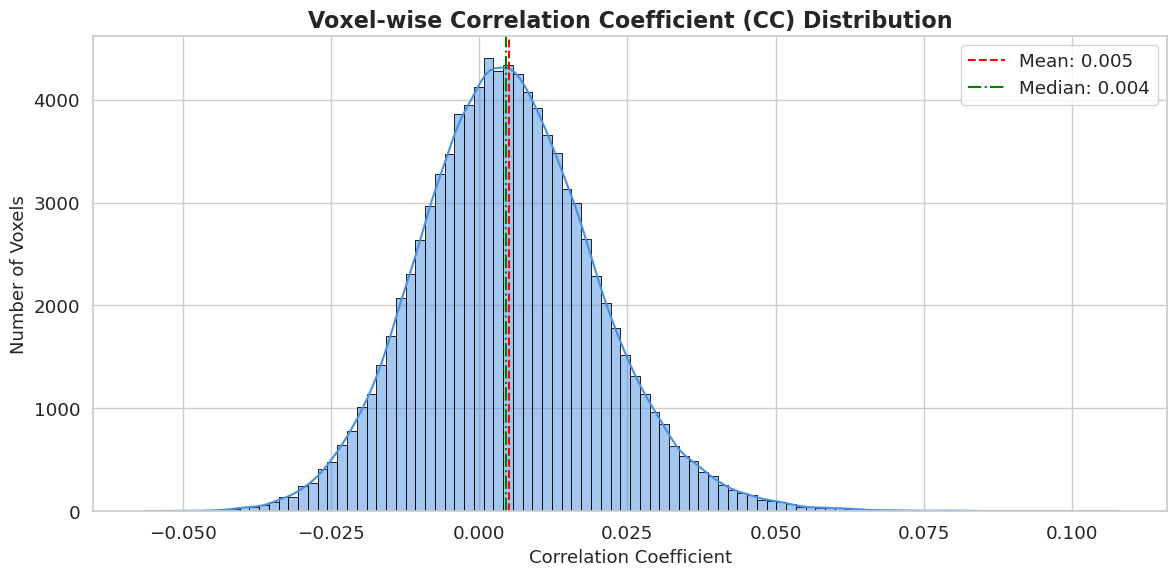

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Remove NaNs
valid_ccs = ccs[~np.isnan(ccs)]

# Set plot style
sns.set(style="whitegrid", font_scale=1.2)

# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram
sns.histplot(valid_ccs, bins=100, kde=True, color="#4A90E2", edgecolor="black", stat="count")

# Add vertical lines for mean and median
plt.axvline(np.mean(valid_ccs), color='red', linestyle='--', label=f"Mean: {np.mean(valid_ccs):.3f}")
plt.axvline(np.median(valid_ccs), color='green', linestyle='-.', label=f"Median: {np.median(valid_ccs):.3f}")

# Titles and labels
plt.title("Voxel-wise Correlation Coefficient (CC) Distribution", fontsize=16, weight="bold")
plt.xlabel("Correlation Coefficient", fontsize=13)
plt.ylabel("Number of Voxels", fontsize=13)
plt.legend()
plt.tight_layout()

save_dir = os.path.join("..", "results")
os.makedirs(save_dir, exist_ok=True)

plot_path = os.path.join(save_dir, "cc_distribution_word2vec_subject2_pretty.png")
plt.savefig(plot_path, dpi=300)

print(f"Plot saved to: {plot_path}")


In [ ]:
# ----- Stability Analysis Across Subjects-----

# Function to compute the correlation coefficient (CC) for each voxel
def compute_cc(y_true, y_pred):
    cc_vals = []
    for v in range(y_true.shape[1]):  # For each voxel
        cc, _ = pearsonr(y_true[:, v], y_pred[:, v])
        cc_vals.append(cc)
    return np.array(cc_vals)

# Function to perform stability analysis across subjects
def stability_analysis_across_subjects(subjects, X_glove_lagged, Y_trimmed, model):
    """
    Perform stability analysis by evaluating model performance across various subjects.
    :param subjects: List of subjects to evaluate.
    :param X_glove_lagged: The feature matrix with lagged GloVe embeddings.
    :param Y_trimmed: The FMRI response matrix.
    :param model: Trained Ridge regression model.
    :return: A list of CC values across subjects and the corresponding subject names.
    """
    cc_values = []
    subject_names = []

    for subject in subjects:
        # Prepare test data for each subject
        X_subject = X_glove_lagged[subject]
        Y_subject = Y_trimmed[subject]

        # Predict using the trained model
        Y_pred = model.predict(X_subject)

        # Compute correlation coefficient (CC) for this subject
        ccs = compute_cc(Y_subject, Y_pred)
        cc_values.append(ccs)
        subject_names.append(subject)

    return cc_values, subject_names

# Example subjects (replace with actual subject names in your case)
subjects = list(X_glove_lagged.keys())

# Perform stability analysis on subjects
cc_values, subject_names = stability_analysis_across_subjects(subjects, X_glove_lagged, Y_trimmed, ridge)

# Convert list of CC values into a numpy array for easier processing
cc_values_array = np.array([np.mean(cc, axis=0) for cc in cc_values])  # Mean CC for each subject

In [ ]:
# ----- Visualize the results -----
# Create a fancy box plot to show the distribution of CC across subjects
plt.figure(figsize=(12, 6))

# Create a box plot using Seaborn
sns.boxplot(data=cc_values_array, palette="Set2")
plt.title('Distribution of Mean Correlation Coefficients (CC) Across Subjects', fontsize=16, weight='bold')
plt.xlabel('Subjects', fontsize=12)
plt.ylabel('Mean Correlation Coefficient (CC)', fontsize=12)

# Customize plot labels and ticks
plt.xticks(ticks=np.arange(len(subject_names)), labels=subject_names, rotation=45)
plt.tight_layout()

# Save the plot to the results directory
save_dir = os.path.join("..", "results")
os.makedirs(save_dir, exist_ok=True)
plot_path = os.path.join(save_dir, "cc_distribution_across_subjects.png")
plt.savefig(plot_path, dpi=300)

print(f"Stability analysis plot saved to: {plot_path}")
plt.show()